In [525]:
from numpy import float32
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
import numpy as np

In [526]:
def RMSE_Loss(actual, predicted):
    return np.sqrt(np.mean(np.square(actual - predicted)))

In [527]:
class DatasetManager():
    def __getPandasFromNumpySeries(self, series, features_sequences=1, target_sequences=1, offset=0):

        dfTemp = pd.DataFrame({"ref": series})
        dfTemp.ref = dfTemp.ref.astype(float)
        for i in range(target_sequences):
            dfTemp['t+'+str(target_sequences-i)] = dfTemp.ref.shift(i)

        dfTemp['t'] = dfTemp.ref.shift(target_sequences)

        for j in range(features_sequences-1):
            dfTemp['t-'+str(j+1)] = dfTemp.ref.shift(target_sequences+j+1)

        dfTemp.drop(columns=["ref"], inplace=True)
        dropLine = features_sequences+target_sequences-1

        if(offset > 0):
            dfTemp['t'] = dfTemp['t'].shift(offset)
            for i in range(features_sequences-1):
                dfTemp['t-'+str(i+1)] = dfTemp['t-'+str(i+1)].shift(offset)
        dfTemp.drop(np.arange(0, dropLine+offset), inplace=True)

        return dfTemp[dfTemp.columns[::-1]].reset_index().drop(columns=["index"])
    
    def __getScaledDataFrame(self, df):
        tempColumns = df.columns
        print(df)
        scaler = MinMaxScaler()
        scalerDf = scaler.fit(df.to_numpy())
        df_scaled = scalerDf.transform(df)
        print(df_scaled)
        return pd.DataFrame(df_scaled, columns=tempColumns)

    def __init__(self, sequences, features_sequences=1, target_sequences=1, offset=0, portion=0.7, portion_validation=0.15):
        self.sequences = sequences
        self.features_sequences = features_sequences
        self.target_sequences = target_sequences
        self.offset = offset
        self.portion = portion
        self.portion_validation = portion_validation
        self.df = self.__getPandasFromNumpySeries(sequences, features_sequences, target_sequences, offset)
        self.sizeDataset = self.df.to_numpy().shape[0]

        self.endUpTrainSet = int(self.sizeDataset*self.portion)
        self.endUpValidationSet = int(self.sizeDataset*self.portion_validation)

    def __len__(self):
        return len(self.sequences)

    def __train_set__(self):
        xCol = self.df[self.df.columns[0:self.features_sequences]].to_numpy()
        yCol = self.df[self.df.columns[self.features_sequences:]].to_numpy()
        return xCol[0: self.endUpTrainSet], yCol[0: self.endUpTrainSet]
    
    def __validation_set__(self):
        xCol = self.df[self.df.columns[0:self.features_sequences]].to_numpy()
        yCol = self.df[self.df.columns[self.features_sequences:]].to_numpy()
        return xCol[self.endUpTrainSet: (self.endUpTrainSet+self.endUpValidationSet)], yCol[self.endUpTrainSet: (self.endUpTrainSet+self.endUpValidationSet)]
    
    def __test_set__(self):
        xCol = self.df[self.df.columns[0:self.features_sequences]].to_numpy()
        yCol = self.df[self.df.columns[self.features_sequences:]].to_numpy()
        return  xCol[(self.endUpTrainSet+self.endUpValidationSet):], yCol[(self.endUpTrainSet+self.endUpValidationSet):]

In [528]:
series = pd.read_csv('../datasets/international-airline-passengers.csv')
series = pd.Series(series["International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60"], dtype=float32)
scaler = MinMaxScaler()
series = series.to_numpy().reshape(-1, 1)
scalerFitted = scaler.fit(series)
series = scalerFitted.transform(series)

In [529]:
class LinearSVRGridSearchCrossValidation():
    def __init__(self, parameters, cv, error):
        self.cv = cv
        self.error = error
        self.__best_models = None
        self.__grid_search = GridSearchCV(
            estimator=LinearSVR(
                tol=1e-4,
                max_iter=1000
            ),
            param_grid=parameters,
            cv=cv,
            n_jobs=-1,
            scoring=make_scorer(error, greater_is_better=False),
            return_train_score=True
        )
    
    def __fit__(self, x_train, y_train):
        print(self.__grid_search.estimator.get_params().keys())
        self.__best_models = self.__grid_search.fit(x_train, y_train)
        return self.__best_models.best_params_, self.__best_models.best_score_
    
    def __validate__(self, x_validate, y_validate):
        y_predict = self.__best_models.predict(x_validate)
        errorLoss = self.error(y_validate, y_predict)
        return y_predict, errorLoss

    def __predict__(self, x_test, y_test, num_steps):
        y_predictions = list()
        errorLoss = None
        inner_test = np.copy(x_test).reshape(1,-1)
        for _ in range(num_steps):
            predict = self.__best_models.predict(inner_test)
            y_predictions.append(predict)
            inner_test = np.concatenate((inner_test.flatten()[1::], np.array(predict)), axis=0).reshape(1,-1)

        errorLoss = self.error(y_test, y_predictions)
        return y_predictions, errorLoss

In [530]:
dataset = DatasetManager(series.flatten(), features_sequences=20, target_sequences=1, portion=0.6, portion_validation=0.20)
dataset.df
train_x, train_y = dataset.__train_set__()
vali_x, vali_y = dataset.__validation_set__()
test_x, test_y = dataset.__test_set__()

dict_keys(['C', 'dual', 'epsilon', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'random_state', 'tol', 'verbose'])
{'C': 1000, 'epsilon': 1e-06, 'fit_intercept': True, 'loss': 'epsilon_insensitive', 'tol': 0.1}
-0.021571676449331684
RMSE TRAIN 0.018197604670068382
RMSE VALIDATE 0.023876623908144944
RMSE TEST 0.23050180131402773


c:\Users\Luca\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


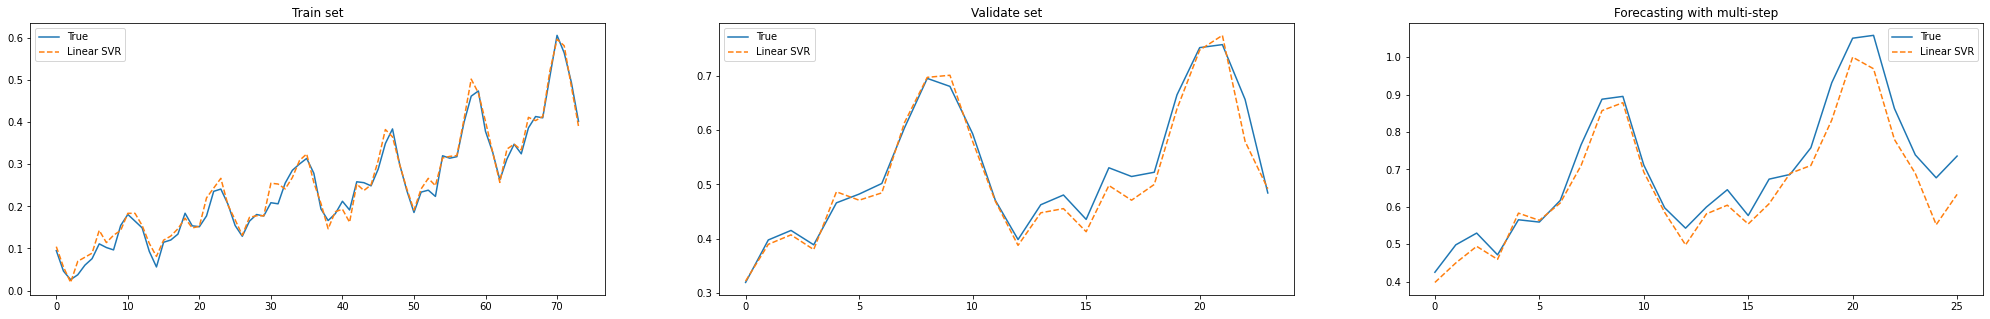

In [531]:
gsg = LinearSVRGridSearchCrossValidation(
    parameters={
        'C': [10, 50, 100, 1000],
        'epsilon': [1e-6, 1e-4, 0.01, 0.1, 0.5],
        'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
        "tol": [1e-2, 0.1],
        'fit_intercept': [True, False]
    },
    cv=5,
    error=RMSE_Loss
)
params, score = gsg.__fit__(train_x, train_y.ravel())
print(params)
print(score)

outputTrain, errorTrain = gsg.__validate__(train_x, train_y.ravel())
outputValidate, errorValidate = gsg.__validate__(vali_x, vali_y.ravel())
outputForecast, errorForecast = gsg.__predict__(test_x[0], test_y.ravel(), 26)

print("RMSE TRAIN", errorTrain)
print("RMSE VALIDATE", errorValidate)
print("RMSE TEST", errorForecast)

plt.figure(figsize=(35,5))

plt.subplot(1,3,1)
plt.title("Train set")
plt.plot(outputTrain)
plt.plot(train_y.flatten(), '--')
plt.legend(["True", "Linear SVR"])


plt.subplot(1,3,2)
plt.title("Validate set")
plt.plot(outputValidate)
plt.plot(vali_y.flatten(), '--')
plt.legend(["True", "Linear SVR"])


plt.subplot(1,3,3)
plt.title("Forecasting with multi-step")
plt.plot(outputForecast)
plt.plot(test_y.flatten(), '--')
plt.legend(["True", "Linear SVR"])